<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/KMVModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm
from scipy.optimize import minimize

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style

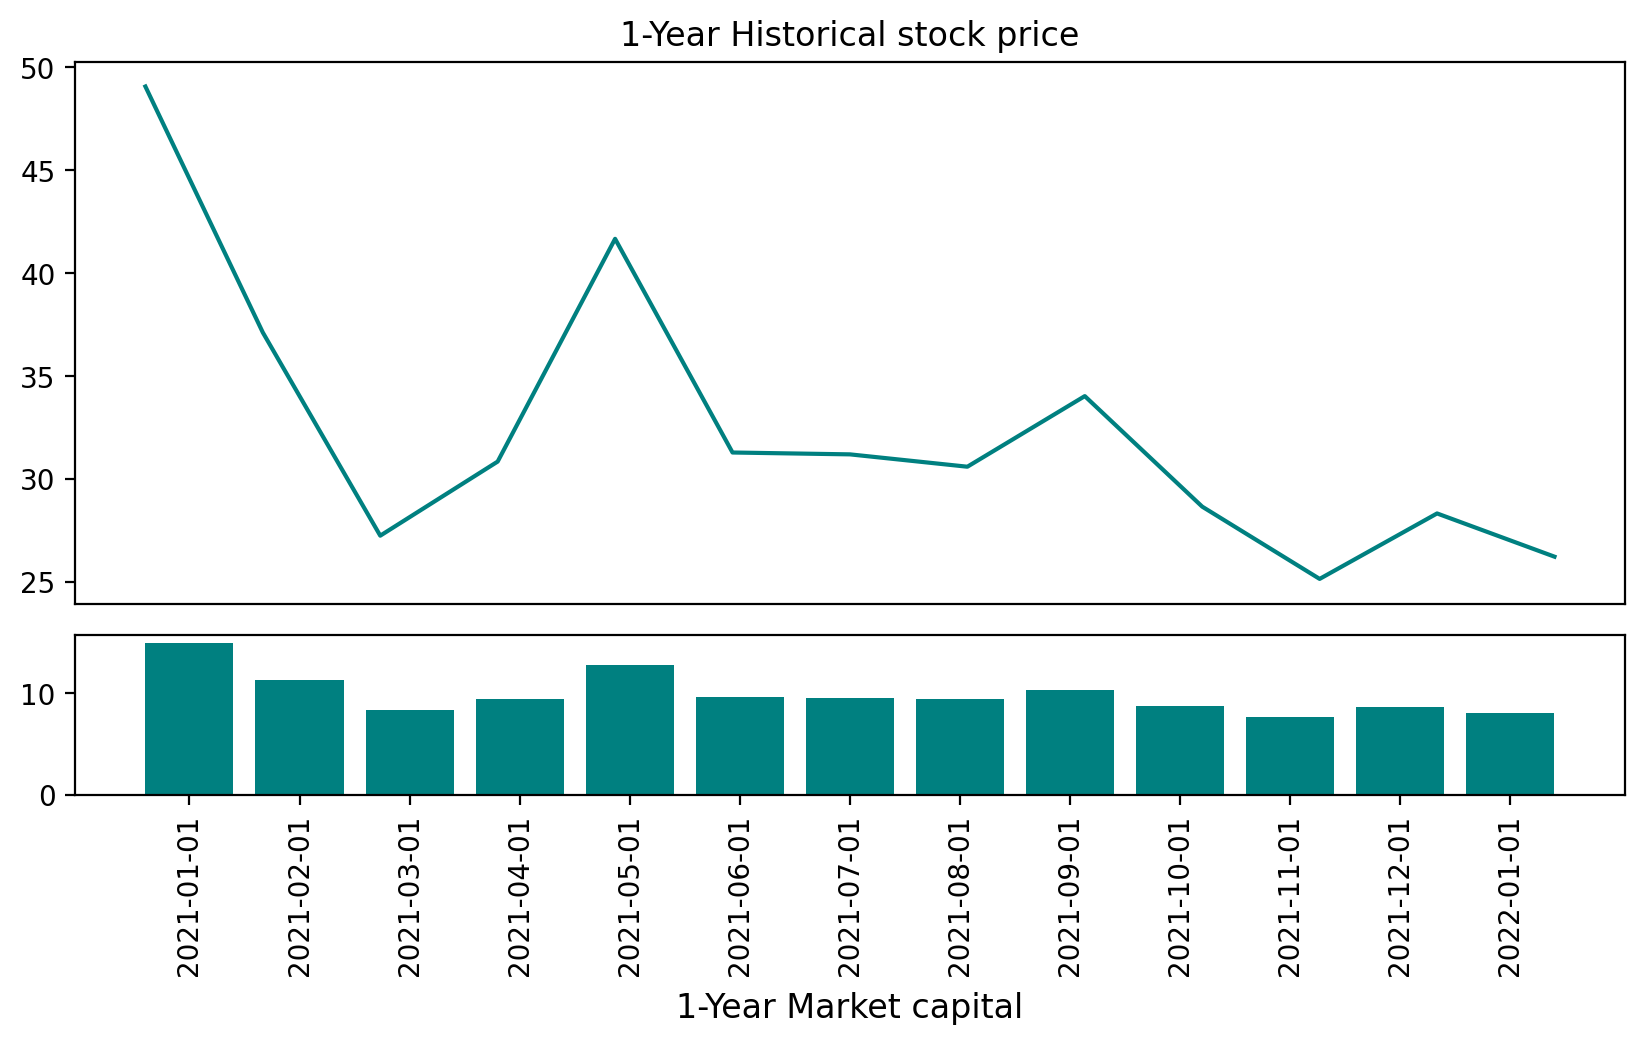

In [3]:
# Import historical price data
priceData = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/PRICE.DATA.csv'
).set_index('Date')

# Calculate market capital and return
priceData['Market Cap'] = priceData['Price'] * priceData['Volume'] / 1000
priceData['Equity return'] = priceData['Market Cap'].pct_change()

# Plot
topPlt = plt.subplot2grid(
    (5, 4),
    (0, 0),
    rowspan = 3,
    colspan = 4
)
topPlt.plot(
    priceData.index,
    priceData['Price'],
    color = 'teal'
)
plt.xticks([])
plt.title('1-Year Historical stock price')
bottomPlt = plt.subplot2grid(
    (5, 4),
    (3, 0),
    rowspan = 1,
    colspan = 4
)
bottomPlt.bar(
    priceData.index,
    priceData['Market Cap'],
    color = 'teal'
)
plt.xticks(rotation = 90)
plt.title(
    '\n1-Year Market capital',
    y = -1.5
)
plt.gcf().set_size_inches(10, 6)
plt.show()

In [4]:
# Import financial statement data
finData = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/FIN.DATA.csv'
).set_index('Year')

# Show table
finData

,2020,2021
Year,,
Asset,2.4726,3.4993
Current liabilities,1.3427,1.3547
Non-Current liabilities,0.6932,0.5421


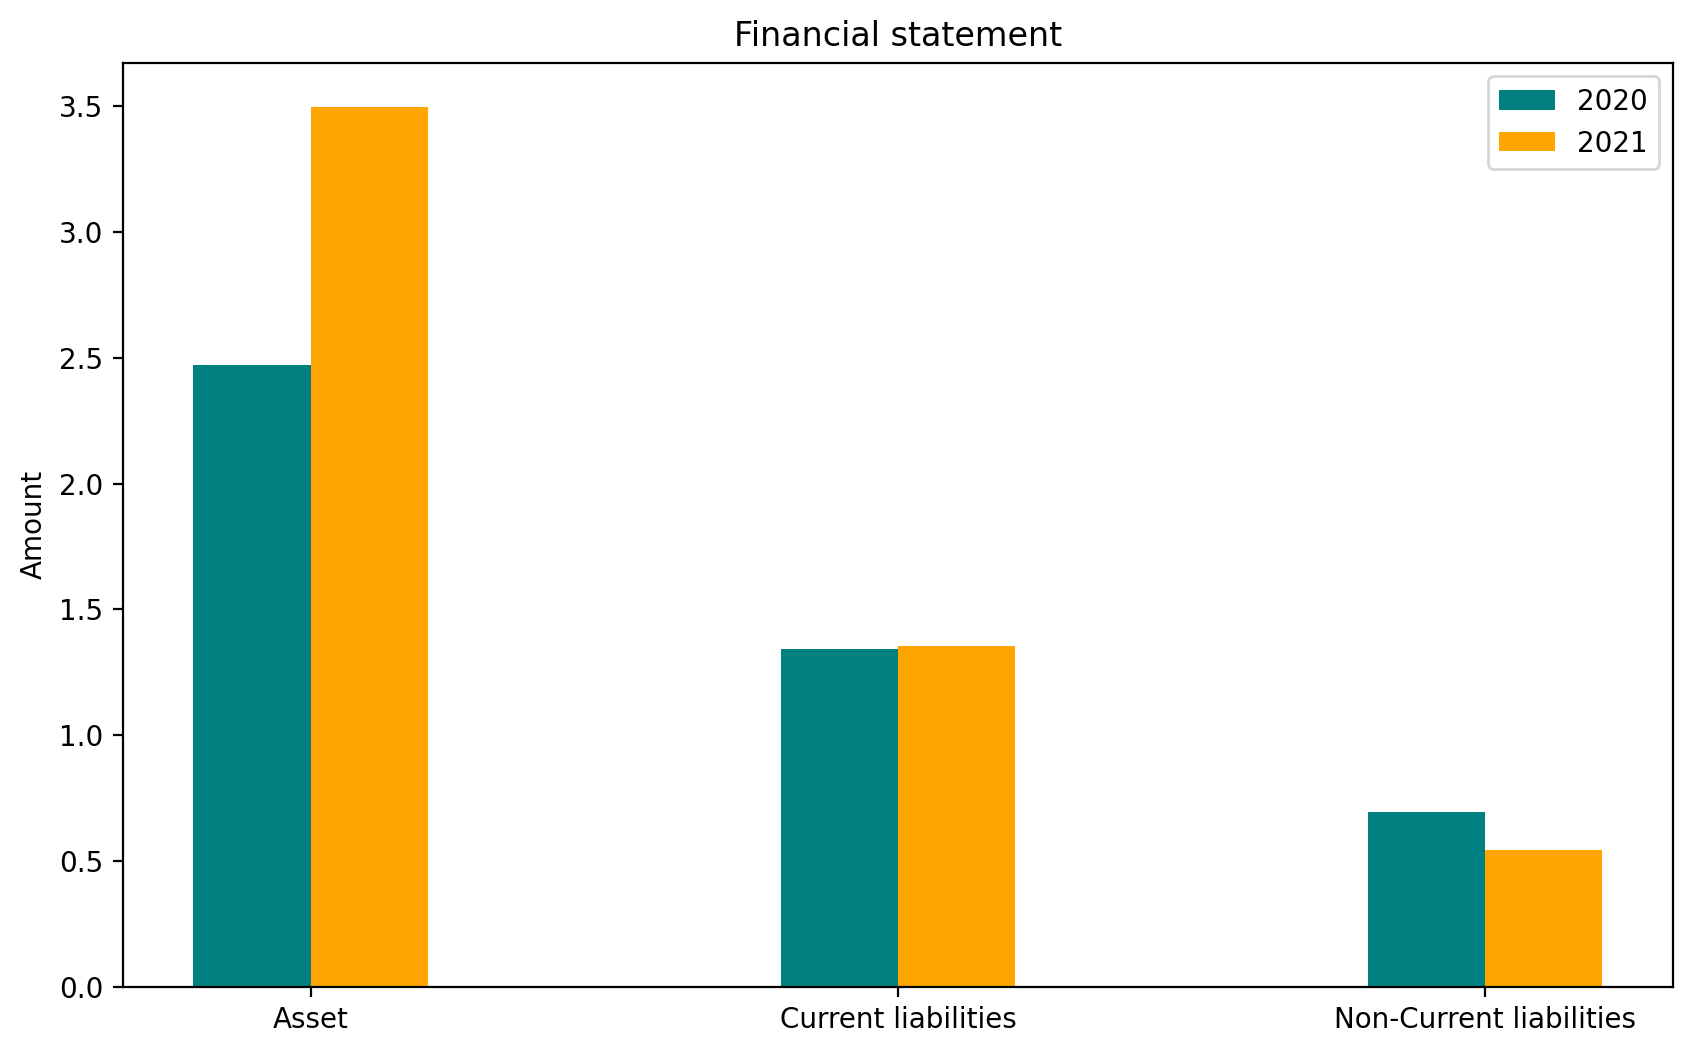

In [5]:
# Plot
plt.figure(figsize = (10, 6))
plt.bar(
    np.arange(finData.shape[0]) - 0.3 / 3,
    finData['2020'],
    0.2,
    color = 'teal',
    label = '2020'
)
plt.bar(
    np.arange(finData.shape[0]) + 0.3 / 3,
    finData['2021'],
    0.2,
    color = 'orange',
    label = '2021'
)
plt.xticks(
    np.arange(finData.shape[0]),
    finData.index
)
plt.legend(
    frameon = True,
    facecolor = 'white'
)
plt.ylabel('Amount')
plt.title('Financial statement')
plt.show()

In [6]:
# Financial statement (liabilities)
DPTPrevious = finData.iloc[1:, 0][0] + 0.5 * finData.iloc[1:, 0][1]
DPTCurrent = finData.iloc[1:, 1][0] + 0.5 * finData.iloc[1:, 1][1]
DPTDiff = DPTCurrent / DPTPrevious - 1 #Percent changed of liabilities
print(f'Previous DPT: {DPTPrevious:.4f}\nCurrent DPT: {DPTCurrent:.4f}\nDPT Diff: {DPTDiff:.4f}')

Previous DPT: 1.6893
Current DPT: 1.6258
DPT Diff: -0.0376


In [7]:
# Define model parameter
RISKFREE = 0.0234 #Thai government bond rate
TIME = 1 #1-Year

In [8]:
# Define KMV Model function
def KMV(x):
  # Finding market volatility by equity return
  priceData['Volatility'] = priceData['Equity return'].std() * np.sqrt(TIME * 12) #Yearly to monthly
  # Convert yearly DPT to monthly DPT using year-on-year percent change to monthly basis
  monthlyDPT = []
  for i in range(0, priceData.shape[0]):
    if i == 0:
      monthlyDPT.append(DPTPrevious)
    else:
      monthlyDPT.append(monthlyDPT[i - 1] * (1 + DPTDiff) ** (1 /12))
  priceData['DPT'] = monthlyDPT
  # d1 and d2 calculation
  priceData['d1'] = (np.log(x / priceData['DPT']) + (priceData['Volatility'] ** 2 / 2 + RISKFREE)) / \
                    (priceData['Volatility'] * np.sqrt(TIME))
  priceData['d2'] = priceData['d1'] - priceData['Volatility'] * np.sqrt(TIME)
  # Compute fair value
  priceData['Fair value'] = x * norm.cdf(priceData['d1']) - \
                            priceData['DPT'] * np.exp(-RISKFREE * TIME) * norm.cdf(priceData['d2'])
  # Cost function (Sum Square Error)
  error = priceData['Market Cap'] - priceData['Fair value']
  return np.sum(error ** 2)

In [9]:
# Initial guess
init = np.random.uniform(
    low = priceData['Market Cap'].min(),
    high = priceData['Market Cap'].max(),
    size = priceData.shape[0]
)

# Finding value of asset
valueAsset = minimize(KMV, init)
valueAsset

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.9926937141883548e-12
        x: [ 1.658e+01  1.290e+01 ...  1.026e+01  9.588e+00]
      nit: 8
      jac: [ 2.298e-06  1.083e-07 ...  7.717e-07 -4.992e-07]
 hess_inv: [[ 7.080e-01 -2.351e-02 ... -6.380e-02 -1.689e-02]
            [-2.351e-02  9.974e-01 ... -1.910e-03  5.482e-04]
            ...
            [-6.380e-02 -1.910e-03 ...  9.693e-01 -3.287e-02]
            [-1.689e-02  5.482e-04 ... -3.287e-02  8.007e-01]]
     nfev: 140
     njev: 10

In [10]:
# Result table
priceData['Value of Asset'] = valueAsset.x

# Show table
priceData

,Price,Volume,Market Cap,Equity return,Volatility,DPT,d1,d2,Fair value,Value of Asset
Date,,,,,,,,,,
2021-01-01,49.05,304.31,14.926405,NaN,0.655282,1.689300,3.848370,3.193088,14.926407,16.576460
2021-02-01,37.10,303.30,11.252430,-0.246139,0.655282,1.683911,3.470190,2.814908,11.252430,12.896735
2021-03-01,27.23,306.31,8.340821,-0.258754,0.655282,1.678538,3.083539,2.428257,8.340821,9.978305
2021-04-01,30.83,306.31,9.443537,0.132207,0.655282,1.673183,3.247780,2.592498,9.443538,11.076678
2021-05-01,41.65,307.30,12.799045,0.355323,0.655282,1.667845,3.656035,3.000753,12.799046,14.427971
2021-06-01,31.27,307.30,9.609271,-0.249220,0.655282,1.662524,3.278801,2.623519,9.609271,11.232132
2021-07-01,31.18,306.30,9.550434,-0.006123,0.655282,1.657220,3.274953,2.619671,9.550434,11.168102
2021-08-01,30.58,307.31,9.397540,-0.016009,0.655282,1.651933,3.258069,2.602787,9.397540,11.009981
2021-09-01,34.01,303.31,10.315573,0.097689,0.655282,1.646663,3.384560,2.729278,10.315573,11.923296


In [11]:
# Calculate parameters
# DPT
DPT = priceData['DPT'][-1] #Lastest available

# Volatility
volatility = np.std(
    priceData['Value of Asset'].pct_change()
) * np.sqrt(TIME * 12)

# Asset value
asset = priceData['Value of Asset'][-1] #Lastest available

In [12]:
# Distance to default
DD = (
    np.log(
        asset / DPT
    ) + (RISKFREE - volatility ** 2 / 2) * TIME
) / (volatility * np.sqrt(TIME))

# Result
print(f'Distance to Default: {DD:.4f}')

Distance to Default: 3.0431


In [13]:
# Probability of Default (PD)
PD = norm.cdf(-DD)

# Result
print(f'Probability of Default: {PD * 100:.2f}%')

Probability of Default: 0.12%
